In [25]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar10
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd

In [26]:
# Carregar os dados CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Verificar as formas dos conjuntos de dados
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

In [27]:
# Normalizar os dados
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [28]:
# Separar um conjunto de validação manualmente
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=0.2, random_state=42)

In [29]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", 
               "dog", "frog", "horse", "ship", "truck"]

In [30]:
#  Early stopping set after 4 epochs
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

# Funções úteis

In [7]:
# defining the function
def evaluate_model(model, X_test, y_test):

    # Evauting the model using teh testing dataset
    eval_dict = model.evaluate(X_test, y_test, return_dict=True)
    
    # converting the evaluation ( accuracy and loss) to pandas dataframe
    result = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    
    # returining dataframe
    return result

In [8]:
# Perda (erro) no treino e validação ao longo das épocas
def plot_loss(history, name):
    plt.plot(history.history['loss'], label='Erro Treino')
    plt.plot(history.history['val_loss'], label='Erro Validação')
    plt.title('Erro por Época - ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('Erro (Perda)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Modelo Baseline

In [9]:
#model = tf.keras.Sequential([
#    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
#    tf.keras.layers.Dense(128, activation='relu'),
#    tf.keras.layers.Dense(10, activation='softmax')
#])

# Definir o modelo
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

In [10]:
model = build_model()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

/home/yagoth/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,634 (1.51 MB)

 Trainable params: 394,634 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Função para treinar e avaliar o modelo sem data augmentation
def train_without_augmentation():
    model = build_model()
    history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[stop_early], verbose=2)
    results = evaluate_model(model, x_val, y_val)
    return results, history

In [12]:
# Aplicando data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Preparando o gerador de dados com data augmentation
datagen.fit(x_train)

# Função para treinar e avaliar o modelo com data augmentation
def train_with_augmentation():
    model = build_model()
    history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                        epochs=20,
                        validation_data=(x_val, y_val),
                        callbacks=[stop_early],
                        verbose=2)
    results = evaluate_model(model, x_val, y_val)
    return results, history

In [13]:
# Treinando sem data augmentation
print("Treinando sem data augmentation...")
results_no_aug, hist_no_aug = train_without_augmentation()

# Treinando com data augmentation
print("Treinando com data augmentation...")
results_with_aug, hist_with_aug = train_with_augmentation()

Treinando sem data augmentation...
Epoch 1/20
1250/1250 - 4s - 3ms/step - accuracy: 0.3162 - loss: 1.9149 - val_accuracy: 0.3587 - val_loss: 1.7943
Epoch 2/20
1250/1250 - 3s - 2ms/step - accuracy: 0.3734 - loss: 1.7599 - val_accuracy: 0.3610 - val_loss: 1.7734
Epoch 3/20
1250/1250 - 3s - 3ms/step - accuracy: 0.3920 - loss: 1.7037 - val_accuracy: 0.4086 - val_loss: 1.6659
Epoch 4/20
1250/1250 - 3s - 2ms/step - accuracy: 0.4055 - loss: 1.6670 - val_accuracy: 0.3968 - val_loss: 1.6808
Epoch 5/20
1250/1250 - 3s - 2ms/step - accuracy: 0.4160 - loss: 1.6466 - val_accuracy: 0.4211 - val_loss: 1.6356
Epoch 6/20
1250/1250 - 3s - 2ms/step - accuracy: 0.4251 - loss: 1.6220 - val_accuracy: 0.4092 - val_loss: 1.6535
Epoch 7/20
1250/1250 - 3s - 3ms/step - accuracy: 0.4282 - loss: 1.6085 - val_accuracy: 0.4027 - val_loss: 1.6836
Epoch 8/20
1250/1250 - 3s - 2ms/step - accuracy: 0.4332 - loss: 1.5895 - val_accuracy: 0.4181 - val_loss: 1.6331
Epoch 9/20
1250/1250 - 3s - 2ms/step - accuracy: 0.4408 - los

/home/yagoth/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/yagoth/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 - 13s - 11ms/step - accuracy: 0.2426 - loss: 2.0734 - val_accuracy: 0.3260 - val_loss: 1.8963
Epoch 2/20
1250/1250 - 13s - 10ms/step - accuracy: 0.2838 - loss: 1.9782 - val_accuracy: 0.3334 - val_loss: 1.8455
Epoch 3/20
1250/1250 - 13s - 10ms/step - accuracy: 0.2962 - loss: 1.9456 - val_accuracy: 0.3527 - val_loss: 1.8140
Epoch 4/20
1250/1250 - 13s - 11ms/step - accuracy: 0.3027 - loss: 1.9185 - val_accuracy: 0.3561 - val_loss: 1.7960
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.3571 - loss: 1.7891


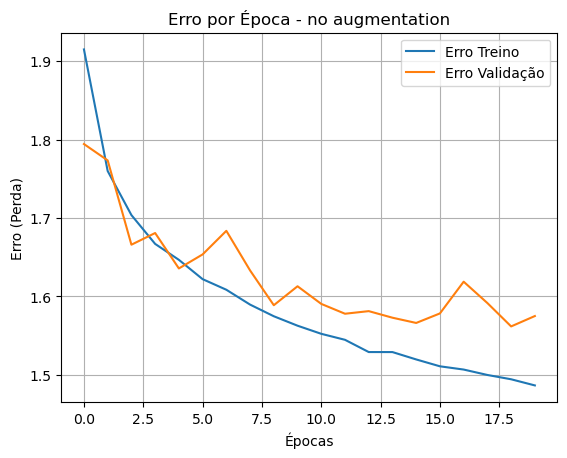

In [14]:
plot_loss(hist_no_aug, 'no augmentation')

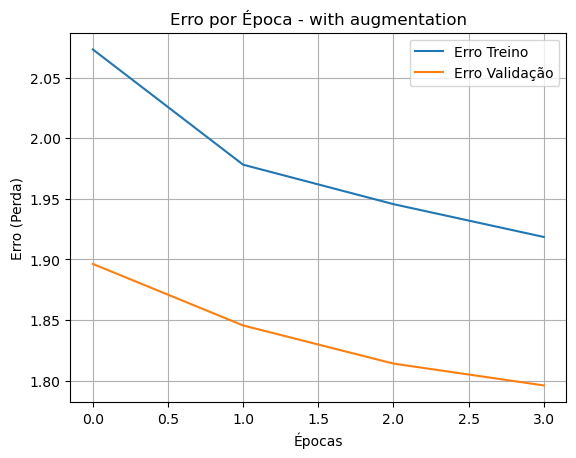

In [15]:
plot_loss(hist_with_aug, 'with augmentation')

In [24]:
# Comparando os resultados
print("Resultados sem data augmentation:")
print(results_no_aug)

print("Resultados com data augmentation:")
print(results_with_aug)

Resultados sem data augmentation:
  accuracy      loss
0   0.4471  1.574953
Resultados com data augmentation:
  accuracy      loss
0   0.3561  1.795953


# Hyperparameter Tuning

In [31]:
# creating function
def build_model(hyper_parameter):

    # building the model
    model = tf.keras.Sequential()

    # flattenting the images
    model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))

    # tunning hidden layers (1-3), units ( 50 -300),
    for i in range(1, hyper_parameter.Int("num_layers", 2, 4)):
        model.add(
            tf.keras.layers.Dense(
                units=hyper_parameter.Int("units_" + str(i), min_value=50, max_value=300, step=30),
                activation="relu")
            )
        
        # drop out layer with values form 0-0.3
        model.add(tf.keras.layers.Dropout(hyper_parameter.Float("dropout_" + str(i), 0, 0.3, step=0.1)))
    
    # Add output layer.
    model.add(tf.keras.layers.Dense(units=10, activation="softmax"))
    
    # Tune learning from 0.01, 0.001
    hyper_parameter_learning_rate = hyper_parameter.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hyper_parameter_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    return model

In [32]:
# early stop function for hyperparameter tuning of neural network
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

## Hyperband

In [34]:
# importing the karas tuner
import keras_tuner as kt

# Instantiate the tuner
tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=10,
                     directory="kt_dir_fcnn",
                     project_name="kt_hyperband_fcnn")

Reloading Tuner from kt_dir/kt_hyperband/tuner0.json


In [ ]:
tuner.search(x_train, y_train,
             epochs=5,
             validation_data=(x_val, y_val),
            callbacks=[stop_early],
            verbose=3)

## Random Search

In [21]:
from keras_tuner import RandomSearch


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  # O objetivo a ser otimizado
    max_trials=3,  # Número de combinações de hiperparâmetros para testar
    executions_per_trial=3,  # Número de execuções para cada conjunto de hiperparâmetros
    directory='my_dir',  # Diretório para salvar os resultados
    project_name='random_search_example'
)

Reloading Tuner from ./random_search_example/tuner0.json


In [22]:
# summary of tuner
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 300, 'step': 30, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 300, 'step': 30, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}


In [23]:
tuner.search(x_train, y_train,
             epochs=5,
             validation_data=(x_val, y_val),
            callbacks=[stop_early])

## Treina com melhores hiperparâmetros

In [24]:
# Get the optimum values for parameters
best_hps=tuner.get_best_hyperparameters()[0]

# Build model on optimum paramters
optimum_model = tuner.hypermodel.build(best_hps)

# Train the hypertuned model
history = optimum_model.fit(x_train, y_train, validation_data=(x_val, y_val),
                            callbacks=[stop_early], epochs=20, verbose=2)

/home/yagoth/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1250/1250 - 6s - 5ms/step - accuracy: 0.3085 - loss: 1.9400 - val_accuracy: 0.3641 - val_loss: 1.7949
Epoch 2/20
1250/1250 - 5s - 4ms/step - accuracy: 0.3806 - loss: 1.7571 - val_accuracy: 0.3838 - val_loss: 1.7372
Epoch 3/20
1250/1250 - 5s - 4ms/step - accuracy: 0.4043 - loss: 1.6835 - val_accuracy: 0.4078 - val_loss: 1.6630
Epoch 4/20
1250/1250 - 5s - 4ms/step - accuracy: 0.4238 - loss: 1.6310 - val_accuracy: 0.4131 - val_loss: 1.6366
Epoch 5/20
1250/1250 - 5s - 4ms/step - accuracy: 0.4399 - loss: 1.5870 - val_accuracy: 0.4247 - val_loss: 1.6244
Epoch 6/20
1250/1250 - 5s - 4ms/step - accuracy: 0.4527 - loss: 1.5557 - val_accuracy: 0.4405 - val_loss: 1.5786
Epoch 7/20
1250/1250 - 5s - 4ms/step - accuracy: 0.4638 - loss: 1.5235 - val_accuracy: 0.4464 - val_loss: 1.5486
Epoch 8/20
1250/1250 - 9s - 8ms/step - accuracy: 0.4746 - loss: 1.4963 - val_accuracy: 0.4459 - val_loss: 1.5489
Epoch 9/20
1250/1250 - 10s - 8ms/step - accuracy: 0.4832 - loss: 1.4698 - val_accuracy: 0.4602 -

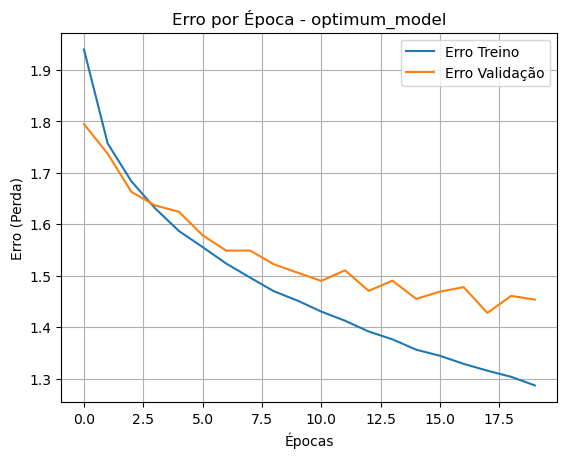

In [25]:
plot_loss(history, 'optimum_model')

In [26]:
# get te optimum models results
hyper_df = evaluate_model(optimum_model, x_test, y_test)

# adding result to the dataframe already created
#results.append(hyper_df)

# printing the results
hyper_df.head()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4940 - loss: 1.4383


,accuracy,loss
0,0.4938,1.44284


# Referências

- https://www.tensorflow.org/tutorials/keras/classification#build_the_model
- https://pyihub.org/hyperparameter-tuning-of-neural-network/
- https://github.com/YounesElhjouji/Fully-Connected-Cifar10-Classifier/blob/master/CIFAR10-Classifier.ipynb
- https://github.com/Mostafa-Mansour/Image-classification-using-a-fully-connected-neural-network-/blob/master/Image%20classification%20using%20Keras.ipynb